# Test

Import usefull packages + the njord library. For installations details please refer to README file. 

In [1]:
import ccxt
import njord as nj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data.

Here we load all the data that is available for binance.

In [ ]:
# Set the hyper parameter.
period = "1h"
exchange = ccxt.binance()
markets = exchange.loadMarkets()

In [33]:
ohlcv = {}

for market in markets.keys():
    data = exchange.fetchOhlcv(market, "1h")
    df = pd.DataFrame(data, columns=["time", "o", "h", "l", "c", "v"])
    df = df.set_index("time")
    df.index = pd.to_datetime(df.index, unit="ms")
    ohlcv[market] = df
    print("Load market = {}".format(market))

Load market = ETH/BTC
Load market = LTC/BTC
Load market = BNB/BTC
Load market = NEO/BTC
Load market = QTUM/ETH
Load market = EOS/ETH
Load market = SNT/ETH
Load market = BNT/ETH
Load market = BCH/BTC
Load market = GAS/BTC
Load market = BNB/ETH
Load market = BTC/USDT
Load market = ETH/USDT
Load market = HSR/BTC
Load market = OAX/ETH
Load market = DNT/ETH
Load market = MCO/ETH
Load market = ICN/ETH
Load market = MCO/BTC
Load market = WTC/BTC
Load market = WTC/ETH
Load market = LRC/BTC
Load market = LRC/ETH
Load market = QTUM/BTC
Load market = YOYOW/BTC
Load market = OMG/BTC
Load market = OMG/ETH
Load market = ZRX/BTC
Load market = ZRX/ETH
Load market = STRAT/BTC
Load market = STRAT/ETH
Load market = SNGLS/BTC
Load market = SNGLS/ETH
Load market = BQX/BTC
Load market = BQX/ETH
Load market = KNC/BTC
Load market = KNC/ETH
Load market = FUN/BTC
Load market = FUN/ETH
Load market = SNM/BTC
Load market = SNM/ETH
Load market = NEO/ETH
Load market = IOTA/BTC
Load market = IOTA/ETH
Load market = LI

Load market = MFT/ETH
Load market = MFT/BNB
Load market = DENT/BTC
Load market = DENT/ETH
Load market = ARDR/BTC
Load market = ARDR/ETH
Load market = ARDR/BNB
Load market = NULS/USDT
Load market = HOT/BTC
Load market = HOT/ETH
Load market = VET/BTC
Load market = VET/ETH
Load market = VET/USDT
Load market = VET/BNB
Load market = DOCK/BTC
Load market = DOCK/ETH
Load market = POLY/BTC
Load market = POLY/BNB
Load market = PHX/BTC
Load market = PHX/ETH
Load market = PHX/BNB
Load market = HC/BTC
Load market = HC/ETH
Load market = GO/BTC
Load market = GO/BNB
Load market = PAX/BTC
Load market = PAX/BNB
Load market = PAX/USDT
Load market = PAX/ETH
Load market = RVN/BTC
Load market = RVN/BNB
Load market = DCR/BTC
Load market = DCR/BNB
Load market = USDC/BNB
Load market = USDC/BTC
Load market = MITH/BTC
Load market = MITH/BNB
Load market = BCHABC/BTC
Load market = BCHSV/BTC
Load market = BCHABC/USDT
Load market = BCHSV/USDT
Load market = BNB/PAX
Load market = BTC/PAX
Load market = ETH/PAX
Load ma

## Build the batch.

We now have to build the batch, i.e. a feature array X with its associated targets Y. 

In [50]:
# Set the initial list.
X = []
Y = []

# Loop on the markets.
for market, data in ohlcv.items():
    batch = nj.Batch(data[["o", "h", "l", "c"]], 16, 1)
    x, y = batch.build(target="c", method="pvt")
    y = 1.0 * ( y > 0.0 ).reshape(-1,1)
    X.append(x)
    Y.append(y)

In [57]:
# Build the entire batch.
X_tr = np.vstack(X)
Y_tr = np.vstack(Y)

# Display features information.
print("\nTraining Features info:")
print("X_tr shape = {}".format(X_tr.shape))
print("X_tr mean  = {}".format(X_tr.mean()))
print("X_tr std   = {}".format(X_tr.std()))
print("X_tr max   = {}".format(X_tr.max()))
print("X_tr min   = {}".format(X_tr.min()))
print("\nTest Features info:")
print("Y_tr shape = {}".format(Y_tr.shape))
print("Y_tr mean  = {}".format(Y_tr.mean()))
print("Y_tr std   = {}".format(Y_tr.std()))


Training Features info:
X_tr shape = (197394, 16, 4)
X_tr mean  = 0.28621809943408116
X_tr std   = 6.608688289510543
X_tr max   = 5119.047619047619
X_tr min   = -98.19742489270386

Test Features info:
Y_tr shape = (197394, 1)
Y_tr mean  = 0.44311883846520156
Y_tr std   = 0.49675399692649896


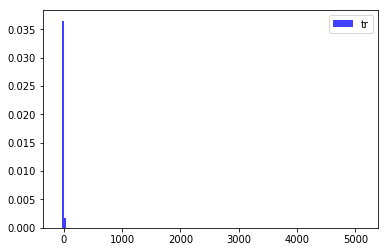

In [55]:
# Histogram: Train and test Features.
hist_X_tr = plt.hist(X_tr.reshape(-1, 1), 200, density=True, facecolor="b", alpha=0.75, label="tr")
plt.legend()
plt.show()

## Training

Train a model with keras.

In [66]:
# Import usefull packages.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GRU
from keras import optimizers
import keras.backend as K

In [67]:
# Define the precision.
def P(y_true, y_pred):
    """Function that computes the precision.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Define the recall.
def R(y_true, y_pred):
    """Function that computes the recall.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [73]:
# Reshape the training dataset.
X_train = X_tr #.reshape(X_tr.shape[0], -1)
Y_train = Y_tr #.reshape(X_tr.shape[0], -1)

# Build the model.
model = Sequential()

"""
model.add(Dense(units=128, activation="relu", input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation="sigmoid"))
"""

model.add(GRU(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
#model.add(GRU(64, return_sequences=False))
model.add(Dense(units=1, activation="sigmoid"))


# Set the optimizer.
optimizer = optimizers.RMSprop(lr=0.001, rho=0.95, epsilon=1.0E-6, decay=0.0)

# Compile the model.
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[R, P])

# Set the training parameters.
params = {
    "epochs": 10,
    "batch_size": 2048,
    "verbose": 1,
    "shuffle": True,
    "validation_split": 0.5
}

# Train the model.
history = model.fit(X_train, Y_train, **params)

# Training finished.
print("Training finished")

Train on 98697 samples, validate on 98697 samples
Epoch 1/10
98697/98697 [==============================] - 19s 188us/step - loss: 0.6832 - R: 0.2541 - P: 0.5453 - val_loss: 0.6748 - val_R: 0.3540 - val_P: 0.5213
Epoch 2/10
98697/98697 [==============================] - 18s 178us/step - loss: 0.6809 - R: 0.2787 - P: 0.5504 - val_loss: 0.6745 - val_R: 0.2743 - val_P: 0.5371
Epoch 3/10
98697/98697 [==============================] - 18s 178us/step - loss: 0.6802 - R: 0.2851 - P: 0.5546 - val_loss: 0.6750 - val_R: 0.3022 - val_P: 0.5316
Epoch 4/10
98697/98697 [==============================] - 18s 179us/step - loss: 0.6800 - R: 0.2966 - P: 0.5534 - val_loss: 0.6759 - val_R: 0.2546 - val_P: 0.5383
Epoch 5/10
98697/98697 [==============================] - 18s 184us/step - loss: 0.6794 - R: 0.2995 - P: 0.5540 - val_loss: 0.6765 - val_R: 0.2282 - val_P: 0.5309
Epoch 6/10
98697/98697 [==============================] - 20s 202us/step - loss: 0.6793 - R: 0.3056 - P: 0.5529 - val_loss: 0.6751 - va

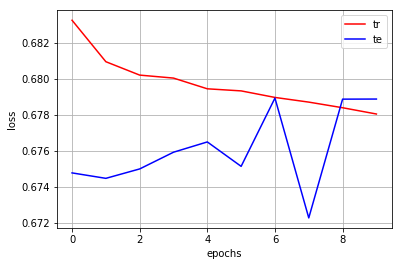

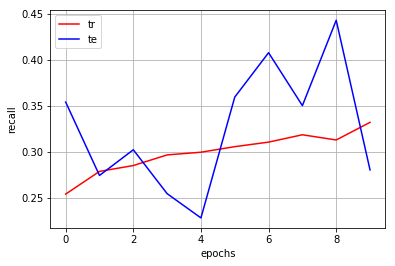

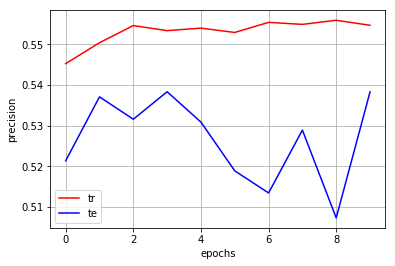

In [74]:
# Figure: loss vs epochs.
plt.figure()
plt.plot(history.history["loss"], label="tr", color="r")
plt.plot(history.history["val_loss"], label="te", color="b")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

# Figure: recall vs. epochs.
plt.figure()
plt.plot(history.history["R"], label="tr", color="r")
plt.plot(history.history["val_R"], label="te", color="b")
plt.xlabel("epochs")
plt.ylabel("recall")
plt.legend()
plt.grid()
plt.show()

# Figure: precision vs. epochs.
plt.figure()
plt.plot(history.history["P"], label="tr", color="r")
plt.plot(history.history["val_P"], label="te", color="b")
plt.xlabel("epochs")
plt.ylabel("precision")
plt.legend()
plt.grid()
plt.show()

In [72]:
# Evaluate the model on th train set.
eval_tr = model.evaluate(X_train, Y_train, verbose=2)

# Evaluate the model on th test set.
eval_te = model.evaluate(X_test, Y_test, verbose=2)

# Display the results.
print("Evaluate model on the training set: \n {}".format(eval_tr))
print("Evaluate model on the test set:     \n {}".format(eval_te))

Evaluate model on the training set: 
 [0.5248513696820596, 0.7534134960790291, 0.7333942605875353]
Evaluate model on the test set:     
 [0.5387816992356296, 0.7332806446079727, 0.6968862744876623]
